# Reading a given dataset (images and masks) and prepare it for training

## 1 - a - Import section for all the libs needed:

In [1]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from natsort import natsorted
from scipy import ndimage
import distancemap as dm
from tqdm import trange
from glob import glob
import numpy as np
import random
import os

## 2 - The paths to the new dataset (example : HeLa cells dataset : celltrackingchallenge.net):

In [2]:
# Path to the datasets
main_dir = os.path.join('..', 'dataset', 'hela_cells_dataset')

##### TRAINING PATHS #####
##########################

# Paths of the training images
train_imgs_path_list = natsorted(glob(os.path.join(main_dir, 'DIC-C2DH-HeLa', '01', '*.tif')))

# Paths of the training masks
train_masks_path_list = natsorted(glob(os.path.join(main_dir, 'DIC-C2DH-HeLa', '01_ST', 'SEG', '*.tif')))

##### TEST PATHS #####
############################

# Paths of the test images
test_imgs_path_list = natsorted(glob(os.path.join(main_dir, 'DIC-C2DH-HeLa', '02', '*.tif')))

# Paths of the test masks
test_masks_path_list = natsorted(glob(os.path.join(main_dir, 'DIC-C2DH-HeLa', '02_ST', 'SEG', '*.tif')))

# Basic information about the dataset
print('Trainig dataset:\n      Number of images : ', len(train_imgs_path_list),'\n      Number of masks : ',len(train_masks_path_list),'\n\n')
print('Testing dataset:\n      Number of images : ', len(test_imgs_path_list),'\n      Number of masks : ',len(test_masks_path_list),'\n\n')

Trainig dataset:
      Number of images :  84 
      Number of masks :  84 


Testing dataset:
      Number of images :  84 
      Number of masks :  84 




<PIL.TiffImagePlugin.TiffImageFile image mode=L size=512x512 at 0x1D19FB80F70>


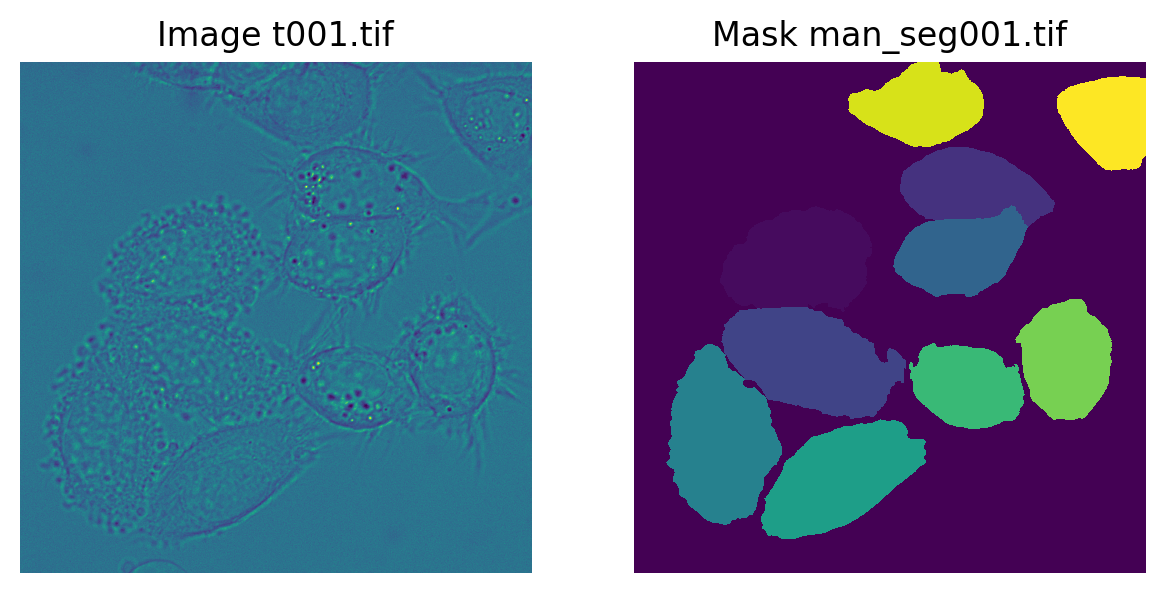

In [3]:
# Get a random index (training imgs)
train_rand_idx = random.randint(0, len(train_imgs_path_list)-1)

print(Image.open(train_imgs_path_list[train_rand_idx]))
plt.figure(dpi=200)
plt.subplot(121)
plt.title('Image '+os.path.basename(train_imgs_path_list[train_rand_idx]))
plt.imshow(Image.open(train_imgs_path_list[train_rand_idx]))
plt.tight_layout()
plt.axis('off')

plt.subplot(122)
plt.title('Mask '+os.path.basename(train_masks_path_list[train_rand_idx]))
plt.imshow(Image.open(train_masks_path_list[train_rand_idx]))
plt.tight_layout()
plt.axis('off')
plt.show()



## 3 - Training/testing dataset preparation:
### 3.1 - Convert masks into binary masks:

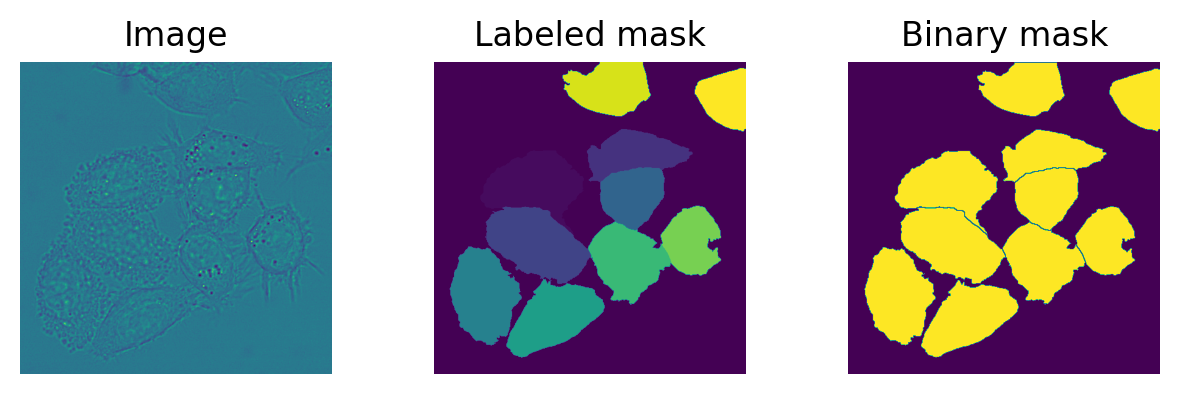

In [4]:
def labeled_mask_to_bn_mask(lb_mask):
    labels = label(lb_mask,connectivity=2)
    new_mask = np.zeros(lb_mask.shape, dtype="uint8")

    for lb in np.unique(labels):

        if lb == 0: continue

        
        temp_mask = np.zeros(lb_mask.shape, dtype="uint8")
        temp_mask[labels == lb] = 255
        
        temp_mask = ndimage.binary_erosion(temp_mask, structure=np.ones((2,2))).astype(temp_mask.dtype)
        temp_mask = ndimage.binary_fill_holes(temp_mask)

        
        rr, cc = np.where(temp_mask==True)
        new_mask[rr, cc] = 255
    
    
    return new_mask


nb_mask = labeled_mask_to_bn_mask(np.array(Image.open(train_masks_path_list[0])))

plt.figure(dpi=200)
plt.subplot(131)
plt.title('Image')
plt.imshow(Image.open(train_imgs_path_list[0]))
plt.tight_layout()
plt.axis('off')

plt.subplot(132)
plt.title('Labeled mask')
plt.imshow(Image.open(train_masks_path_list[0]))
plt.tight_layout()
plt.axis('off')

plt.subplot(133)
plt.title('Binary mask')
plt.imshow(nb_mask)
plt.tight_layout()
plt.axis('off')
plt.show()


### 3.2 - Guassian density cell masks:

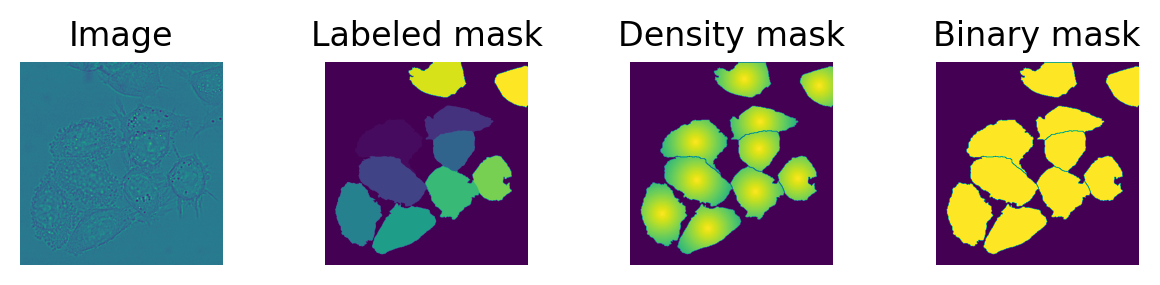

In [5]:
def get_density_mask(mask):

    new_mask = labeled_mask_to_bn_mask(mask)
    
  

    labels = label(new_mask)

    new_mask = np.zeros(mask.shape, dtype="uint8")
    for region in regionprops(labels):
        
        cord = np.array(region.centroid,dtype=np.int64)
        
        dm_mask = np.zeros(mask.shape).astype(bool)
        dm_mask[cord[0],cord[1]] = True

        gauss_dist = dm.distance_map_from_binary_matrix(dm_mask,distance="euclidean", alpha="linear")
        new_mask[labels == region.label] = 255 - gauss_dist[labels == region.label]
    
    return new_mask/np.max(new_mask)


density_cell_mask = get_density_mask(np.array(Image.open(train_masks_path_list[0])))


plt.figure(dpi=200)
plt.subplot(141)
plt.title('Image')
plt.imshow(Image.open(train_imgs_path_list[0]))
plt.tight_layout()
plt.axis('off')

plt.subplot(142)
plt.title('Labeled mask')
plt.imshow(Image.open(train_masks_path_list[0]))
plt.tight_layout()
plt.axis('off')

plt.subplot(143)
plt.title('Density mask')
plt.imshow(density_cell_mask)
plt.tight_layout()
plt.axis('off')

plt.subplot(144)
plt.title('Binary mask')
plt.imshow(nb_mask)
plt.tight_layout()
plt.axis('off')
plt.show()


### 3.3 - Data augmentation on training and validation:

In [6]:
# Paths to save the prepared dataset
main_new_dir =  os.path.join('..', 'dataset', 'augmented_hela_cells_dataset')

# Path to the augmented training dataset
train_aug_dir = os.path.join(main_new_dir, 'train')
os.makedirs(train_aug_dir, exist_ok = True) # Creating the folder

# Path to the augmented validation dataset
val_aug_dir = os.path.join(main_new_dir, 'val')
os.makedirs(val_aug_dir, exist_ok = True) # Creating the folder

# Path to the augmented testing dataset
test_aug_dir = os.path.join(main_new_dir, 'test')
os.makedirs(test_aug_dir, exist_ok = True) # Creating the folder

# Split the training dataset into 80% train and 20% validation
last_train_idx = int(len(train_imgs_path_list)*0.8)

train_imgs_list = train_imgs_path_list[0:last_train_idx]
train_masks_list = train_masks_path_list[0:last_train_idx]

val_imgs_list = train_imgs_path_list[last_train_idx:len(train_imgs_path_list)]
val_masks_list = train_masks_path_list[last_train_idx:len(train_imgs_path_list)]


print('All   train dataset images : ', len(train_imgs_path_list))
print('(80%) train         images : ', len(train_imgs_list))
print('(20%) validation    images : ', len(val_imgs_list))




All   train dataset images :  84
(80%) train         images :  67
(20%) validation    images :  17


In [7]:
def simple_data_augmentation(np_img, dir_path, global_count, prefix=''):
	current_image = Image.fromarray(np_img)
	
	mirror_image = ImageOps.mirror(current_image)

	# Saving the images
	current_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1

	mirror_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1
	
	# Retating images (data augmentation)
	current_image = current_image.rotate(90)
	mirror_image = ImageOps.mirror(current_image)

	# Saving the images
	current_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1

	mirror_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1

	# Retating images (data augmentation)
	current_image = current_image.rotate(90)
	mirror_image = ImageOps.mirror(current_image)
	
	# Saving the images
	current_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1

	mirror_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1

	# Retating images (data augmentation)
	current_image = current_image.rotate(90)
	mirror_image = ImageOps.mirror(current_image)
	
	# Saving the images
	current_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1

	mirror_image.save(os.path.join(dir_path, str(global_count)+prefix+".tif"))
	global_count+=1

	return global_count

print('[INFO] Data augmentation for training dataset ...')
count = 0
for i in trange(len(train_imgs_list)):
	# Reading the current image
	current_image = np.array(Image.open(train_imgs_list[i]))

	# Reading the current mask
	current_mask = np.array(Image.open(train_masks_list[i]))
	
	# Image values between [0, 1]
	if current_image.max() > 1: current_image = current_image / 255

	# Do data augmentation for the images of the training dataset
	_ = simple_data_augmentation(current_image, train_aug_dir, count, prefix='_img')
	
	# Do data augmentation for the binary masks of the training dataset
	current_bn_mask = labeled_mask_to_bn_mask(current_mask)
	_ = simple_data_augmentation(current_bn_mask, train_aug_dir, count, prefix='_binary_mask')

	# Do data augmentation for the density masks of the training dataset
	current_density = get_density_mask(current_bn_mask)
	count = simple_data_augmentation(current_density, train_aug_dir, count, prefix='_density_mask')

print('[INFO] Data augmentation for validation dataset ...')
count = 0
for i in trange(len(val_imgs_list)):
	# Reading the current image
	current_image = np.array(Image.open(val_imgs_list[i]))

	# Reading the current mask
	current_mask = np.array(Image.open(val_masks_list[i]))
	
	# Image values between [0, 1]
	if current_image.max() > 1: current_image = current_image / 255

	# Do data augmentation for the images of the validation dataset
	_ = simple_data_augmentation(current_image, val_aug_dir, count, prefix='_img')
	
	# Do data augmentation for the binary masks of the validation dataset
	current_bn_mask = labeled_mask_to_bn_mask(current_mask)
	_ = simple_data_augmentation(current_bn_mask, val_aug_dir, count, prefix='_binary_mask')

	# Do data augmentation for the density masks of the validation dataset
	current_density = get_density_mask(current_bn_mask)
	count = simple_data_augmentation(current_density, val_aug_dir, count, prefix='_density_mask')

[INFO] Data augmentation for training dataset ...


100%|██████████| 67/67 [00:23<00:00,  2.84it/s]


[INFO] Data augmentation for validation dataset ...


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


### 3.4 - Preparing the testing dataset:

In [8]:
print('[INFO] Preparing the testing dataset ...')
count = 0
for i in trange(len(test_imgs_path_list)):
	# Reading the current image
	current_image = np.array(Image.open(test_imgs_path_list[i]))

	# Reading the current mask
	current_mask = np.array(Image.open(test_masks_path_list[i]))

	# Image values between [0, 1]
	if current_image.max() > 1: current_image = current_image / 255

	# Save the current test image
	current_image = Image.fromarray(current_image)
	current_image.save(os.path.join(test_aug_dir, str(count)+"_img.tif"))

	# Save the testing mask
	current_bn_mask = labeled_mask_to_bn_mask(current_mask)
	current_bn_mask = Image.fromarray(current_bn_mask)
	current_bn_mask.save(os.path.join(test_aug_dir, str(count)+"_binary_mask.tif"))


	# Save the testing density
	current_density = get_density_mask(current_mask)
	current_density = Image.fromarray(current_density)
	current_density.save(os.path.join(test_aug_dir, str(count)+"_density_mask.tif"))

	count+= 1

[INFO] Preparing the testing dataset ...


100%|██████████| 84/84 [00:24<00:00,  3.37it/s]
